# 训练轮数与callbacks
在本例中，通过比较**同样结构**，**同样优化器**，**同样数据集**下**不同epoch**以及**不同callbacks方法**下训练的值得出训练轮数与callbacks方法对训练的影响。

In [1]:
# !pip install --upgrade keras_applications keras

## 引入相关的包

In [2]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
import numpy as np

from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.models import load_model

from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


## 读取数据

In [3]:
import os
from PIL import Image
def load_data():
    dirname = "./data"
    path = "./data"

    num_train_samples = 25000

    x_train = np.empty((num_train_samples, 224,224,3), dtype='uint8')
    y_train = np.empty((num_train_samples,1), dtype='uint8')
    index = 0
    for file in os.listdir("./data"):
        image = Image.open(os.path.join(dirname,file)).resize((224,224))
        image = np.array(image)
        x_train[index,:,:,:] = image

        if "cat" in file:
            y_train[index,0] =1
        elif "dog" in file:
            y_train[index,0] =0

        index += 1
    return (x_train, y_train)

In [4]:
(x_train, y_train) = load_data()

In [5]:
print(x_train.shape)
print(y_train.shape)

(25000, 224, 224, 3)
(25000, 1)


## 数据处理

In [6]:
from keras.utils import np_utils
def process_data(x_train,y_train):
    x_train = x_train.astype(np.float32)
    x_train /= 255
    n_classes = 2
    y_train = np_utils.to_categorical(y_train, n_classes)
    return x_train,y_train

In [8]:
x_train,y_train= process_data(x_train,y_train)
print(x_train.shape)
print(y_train.shape)

(25000, 224, 224, 3)
(25000, 2)


## 构建模型

In [7]:
def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(2, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    print(type(model))
    return model

In [9]:
base_model = VGG16(weights=None, include_top=False)

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
model = build_model(base_model)
model.summary()

<class 'keras.engine.training.Model'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, No

## 模型训练

### 5 epoch训练

In [11]:
import keras 
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


In [12]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(monitor='val_acc', baseline=0.9, patience=30, verbose=1, mode='auto')
cp = ModelCheckpoint(filepath="./model/ckp_vgg16_dog_and_cat.h5", monitor="val_acc", verbose=1, save_best_only=True, mode="auto", period=1)
lr = ReduceLROnPlateau(monitor="val_acc", factor=0.1, patience=10, verbose=1, mode="auto", min_lr=0)
callbacks = [es,cp,lr]

In [13]:
history = model.fit(x=x_train, 
                  y=y_train, 
                  batch_size=32, 
                  epochs=5, 
                  verbose=1, 
                  callbacks=callbacks, 
                  validation_split=0.1, 
                  shuffle=True, 
                  initial_epoch=0, 
                 )

Instructions for updating:
Use tf.cast instead.
Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22500/22500 [==============================] - 110s 5ms/step - loss: 0.6681 - acc: 0.5827 - val_loss: 0.6254 - val_acc: 0.6564

Epoch 00001: val_acc improved from -inf to 0.65640, saving model to ./model/ckp_vgg16_dog_and_cat.h5
Epoch 2/5
22500/22500 [==============================] - 106s 5ms/step - loss: 0.6132 - acc: 0.6659 - val_loss: 0.5633 - val_acc: 0.7024

Epoch 00002: val_acc improved from 0.65640 to 0.70240, saving model to ./model/ckp_vgg16_dog_and_cat.h5
Epoch 3/5
22500/22500 [==============================] - 107s 5ms/step - loss: 0.5473 - acc: 0.7242 - val_loss: 0.7010 - val_acc: 0.6488

Epoch 00003: val_acc did not improve from 0.70240
Epoch 4/5
22500/22500 [==============================] - 107s 5ms/step - loss: 0.4898 - acc: 0.7708 - val_loss: 0.5868 - val_acc: 0.6668

Epoch 00004: val_acc did not improve from 0.70240
Epoch 5/5
22500/22500 [=======================

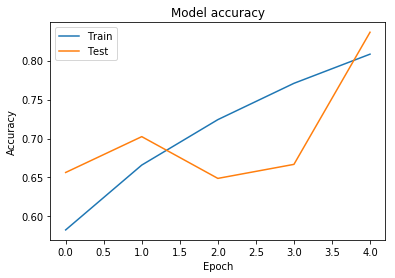

In [19]:
import matplotlib.pyplot as plt

# 绘制训练 & 验证的准确率值
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

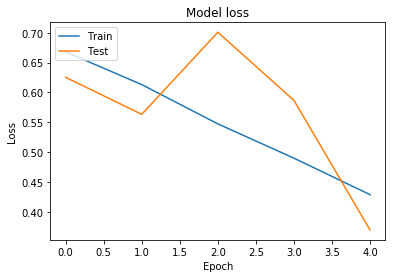

In [15]:
# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### 50 epoch 训练
**在下面的训练中，epoch的数值由5变为50**
#### Epoch
每一个epoch，训练集中的每一条数据都进行一次训练。
在Epoch数值较小时，出现了上一个训练中出现的欠拟合情况，模型没有很好收敛训练便结束了。在接下来的训练中，我们提高了epoch的值，通过训练结果我们可以看到模型逐渐收敛。但是epoch的值并非越大越好，过大的epoch值可能会导致过拟合现象。

![over-fitting](./img/fitting.png)

epoch的值没有具体的公式进行计算，需要根据经验和具体的情况进行制定。

#### ModelCheckpoint
在模型训练过程中，ModelCheckpoint将出现的最好的权重进行保存。
在下面的训练中，每一次出现更好的模型，epoch完成后都进行了保存。

#### ReduceLROnPlateau
学习率衰减方法，在指定epoch数量结束后检测指标时候有提升，如果提升较小，便进行学习率衰减。在接下来的训练中，通过`ReduceLROnPlateau`方法，学习率进行了多次调整，调整之后的模型的指标有所提升。

In [16]:
history_more_steps = model.fit(x=x_train, 
                  y=y_train, 
                  batch_size=32, 
                  epochs=50, 
                  verbose=1, 
                  callbacks=callbacks, 
                  validation_split=0.1, 
                  shuffle=True, 
                  initial_epoch=0, 
                 )

Train on 22500 samples, validate on 2500 samples
Epoch 1/50
22500/22500 [==============================] - 105s 5ms/step - loss: 0.3485 - acc: 0.8493 - val_loss: 0.3592 - val_acc: 0.8384

Epoch 00001: val_acc improved from 0.83640 to 0.83840, saving model to ./model/ckp_vgg16_dog_and_cat.h5
Epoch 2/50
22500/22500 [==============================] - 105s 5ms/step - loss: 0.2864 - acc: 0.8793 - val_loss: 0.3462 - val_acc: 0.8456

Epoch 00002: val_acc improved from 0.83840 to 0.84560, saving model to ./model/ckp_vgg16_dog_and_cat.h5
Epoch 3/50
22500/22500 [==============================] - 105s 5ms/step - loss: 0.2412 - acc: 0.8995 - val_loss: 0.2485 - val_acc: 0.8996

Epoch 00003: val_acc improved from 0.84560 to 0.89960, saving model to ./model/ckp_vgg16_dog_and_cat.h5
Epoch 4/50
22500/22500 [==============================] - 105s 5ms/step - loss: 0.2058 - acc: 0.9150 - val_loss: 0.2857 - val_acc: 0.8692

Epoch 00004: val_acc did not improve from 0.89960
Epoch 5/50
22500/22500 [=========

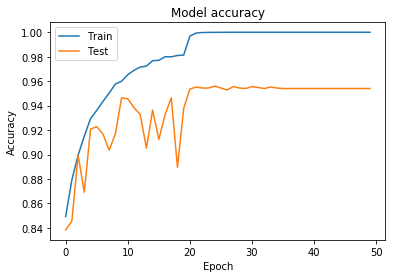

In [17]:
import matplotlib.pyplot as plt

# 绘制训练 & 验证的准确率值
plt.plot(history_more_steps.history['acc'])
plt.plot(history_more_steps.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

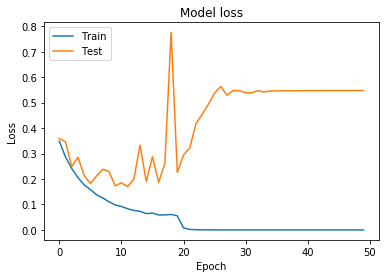

In [18]:
# 绘制训练 & 验证的损失值
plt.plot(history_more_steps.history['loss'])
plt.plot(history_more_steps.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### EarlyStopping 早停法
根据上一个训练可以看到，在训练的后期模型的loss和acc数值已经稳定，这时候继续训练没有对数值产生影响还有可能产生过拟合情况，所以需要及时将模型训练停止。EarlyStopping（早停法）检测模型的某一项指标，如果在指定步数中指标没有提升，则将模型训练停止。

在下面的训练中可以看到模型已经很好收敛了，模型在训练中几乎没有提升空间了，所以没有完成fit函数中规定的50个epoch，而是在第6个epoch完成后训练便停止了。

In [20]:
es = EarlyStopping(monitor='val_acc', baseline=0.9, patience=5, verbose=1, mode='auto')
cp = ModelCheckpoint(filepath="./model/ckp_vgg16_dog_and_cat.h5", monitor="val_acc", verbose=1, save_best_only=True, mode="auto", period=1)
lr = ReduceLROnPlateau(monitor="val_acc", factor=0.1, patience=2, verbose=1, mode="auto", min_lr=0)
callbacks = [es,cp,lr]

In [27]:
history_steps_55 = model.fit(x=x_train, 
                  y=y_train, 
                  batch_size=32, 
                  epochs=50, 
                  verbose=1, 
                  callbacks=callbacks, 
                  validation_split=0.5, 
                  shuffle=True, 
                  initial_epoch=0, 
                 )

Train on 12500 samples, validate on 12500 samples
Epoch 1/50
12500/12500 [==============================] - 75s 6ms/step - loss: 1.0962e-07 - acc: 1.0000 - val_loss: 0.1095 - val_acc: 0.9909

Epoch 00001: val_acc did not improve from 0.99088
Epoch 2/50
12500/12500 [==============================] - 75s 6ms/step - loss: 1.0962e-07 - acc: 1.0000 - val_loss: 0.1095 - val_acc: 0.9909

Epoch 00002: val_acc did not improve from 0.99088
Epoch 3/50
12500/12500 [==============================] - 75s 6ms/step - loss: 1.0962e-07 - acc: 1.0000 - val_loss: 0.1095 - val_acc: 0.9909

Epoch 00003: val_acc did not improve from 0.99088

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.
Epoch 4/50
12500/12500 [==============================] - 75s 6ms/step - loss: 1.0962e-07 - acc: 1.0000 - val_loss: 0.1095 - val_acc: 0.9909

Epoch 00004: val_acc did not improve from 0.99088
Epoch 5/50
12500/12500 [==============================] - 75s 6ms/step - loss: 1.0962e-07 - acc: 1.0

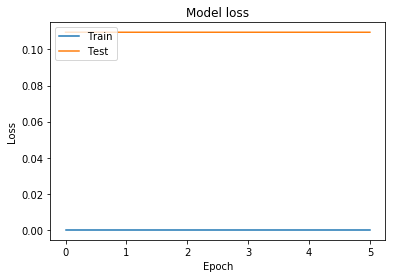

In [28]:
# 绘制训练 & 验证的损失值
plt.plot(history_steps_55.history['loss'])
plt.plot(history_steps_55.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

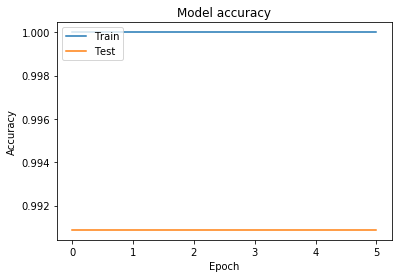

In [31]:
# 绘制训练 & 验证的准确率值
plt.plot(history_steps_55.history['acc'])
plt.plot(history_steps_55.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 拓展
模型在训练过程中还有那些可以提升的地方？

- 可以尝试更多的epoch数量
- 可以尝试自己定义学习率衰减规律。使用`LearningRateScheduler`方法，自己定义学习率衰减。